In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt, argparse, numpy as np, math, sys, copy
from skimage.segmentation import slic, mark_boundaries, felzenszwalb
from skimage.util import img_as_float
from scipy.cluster import hierarchy
from skimage import io
from collections import defaultdict
import numpy as np
import superpixels as sp
import plot as pl
import process_ground_truth as pgt
import glob
import eval_boundary as ev
import pipeline as pipe
import time

### Load images

In [4]:
ground_path = 'BSDS500/data/groundTruth/val/'
train_path = 'BSDS500/data/images/val/'
save_path = 'save/'
extension = '.npz'

In [5]:
len_ground = len(ground_path)
ground_files = glob.glob(ground_path + '*.mat')
ground_filenames = [x[len_ground:-4] for x in ground_files]

groundtruths, images, names = [], [], []

#load images
for filename in ground_filenames:
    ground_file = ground_path + filename + '.mat'
    train_file = train_path + filename + '.jpg'
    
    #read groundtruth and image
    groundtruth = pgt.get_groundTruth(ground_file)
    image = img_as_float(io.imread(train_file))
    
    #append image and groundtruths
    groundtruths.append(groundtruth)
    images.append(image)
    names.append(filename + '.png')
    
print(len(groundtruths), len(images))

100 100


### Load evaluations and calculate f-measures

In [6]:
avg_measures, max_measures = [], []

In [7]:
bound_prefix = save_path + 'bound_'
eval_prefix = save_path + 'precision_'

methods = ['sgb', 'egb', 'slic']

for method in methods:
    evalname = eval_prefix + method + extension

    #load bound file
    npload = np.load(evalname)
    precisions = npload['precisions']
    recalls = npload['recalls']

    np_precisions = (np.array(precisions))
    np_recalls = (np.array(recalls))

    fmeasure = 2 * ((np_precisions * np_recalls) / (np_precisions + np_recalls))
    
    avg_measures.append(np.average(fmeasure))
    max_measures.append(np.max(fmeasure))

In [9]:
bound_prefix = 'images/'
eval_prefix = 'eval/'

methods = ['hslic', 'hsgb', 'hegb']

for method in methods:
    precisions, recalls = [], []
    fmeasures = []
    
    for name in names:
        evalname = save_path + method + '/' + eval_prefix + name + extension
        npload = np.load(evalname)
        precisions.append(npload['precisions'])
        recalls.append(npload['recalls'])

    for i in range(0,len(precisions[0])):
        cutz_precision, cutz_recall = [], []
        
        for precision, recall in zip(precisions, recalls):
            cutz_precision.append(precision[i])
            cutz_recall.append(recall[i])
    
        np_precisions = (np.array(cutz_precision))
        np_recalls = (np.array(cutz_recall))

        fmeasure = 2 * ((np_precisions * np_recalls) / (np_precisions + np_recalls))
        fmeasures.append(fmeasure)
    
    avgs = np.average(fmeasures, axis=1)
    avg_measures.append(np.max(avgs))
    
    maxs = np.max(fmeasures, axis=1)
    max_measures.append(np.max(maxs))

In [10]:
print(avg_measures)
print(max_measures)

[0.2443775247147596, 0.2452815696241912, 0.14854919218932358, 0.17597803354377778, 0.23834142274803533, 0.24691184234020988]
[0.48388036511944066, 0.46218944099378884, 0.2536400284562485, 0.30306127663923949, 0.4997236042012162, 0.47843400259881796]


### Plot curve

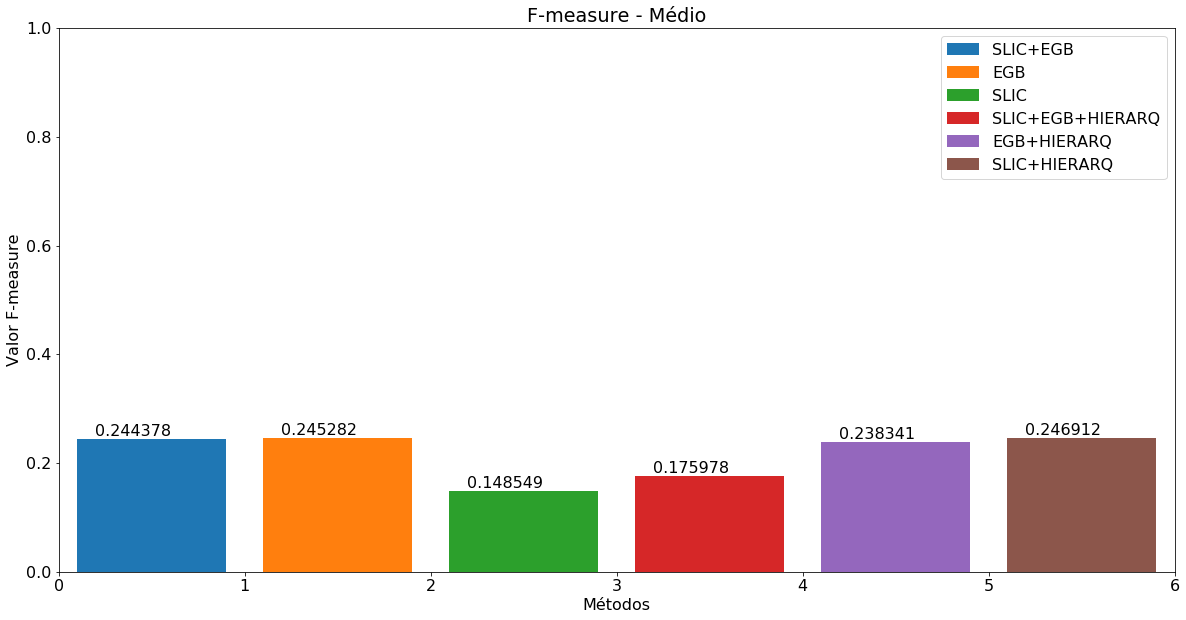

In [40]:
#plot curves
plt.figure(figsize=(20,10))

bar1 = plt.bar(0.5, avg_measures[0], label='SLIC+EGB') #, marker='o', markersize=5, linewidth=0)
bar2 = plt.bar(1.5, avg_measures[1], label='EGB')
bar3 = plt.bar(2.5, avg_measures[2], label='SLIC')
bar4 = plt.bar(3.5, avg_measures[3], label='SLIC+EGB+HIERARQ')
bar5 = plt.bar(4.5, avg_measures[4], label='EGB+HIERARQ')
bar6 = plt.bar(5.5, avg_measures[5], label='SLIC+HIERARQ')

plt.rcParams["font.size"] = 16
plt.legend(loc=0.)
plt.axis([0, 6, 0, 1])

for rect in (bar1 + bar2 + bar3 + bar4 + bar5 + bar6):
    height = rect.get_height()
    plt.text(rect.get_x()+0.3, height, '%2f' % height, ha='center', va='bottom')

plt.xlabel('Métodos')
plt.ylabel('Valor F-measure')
plt.title('F-measure - Médio')
plt.show()

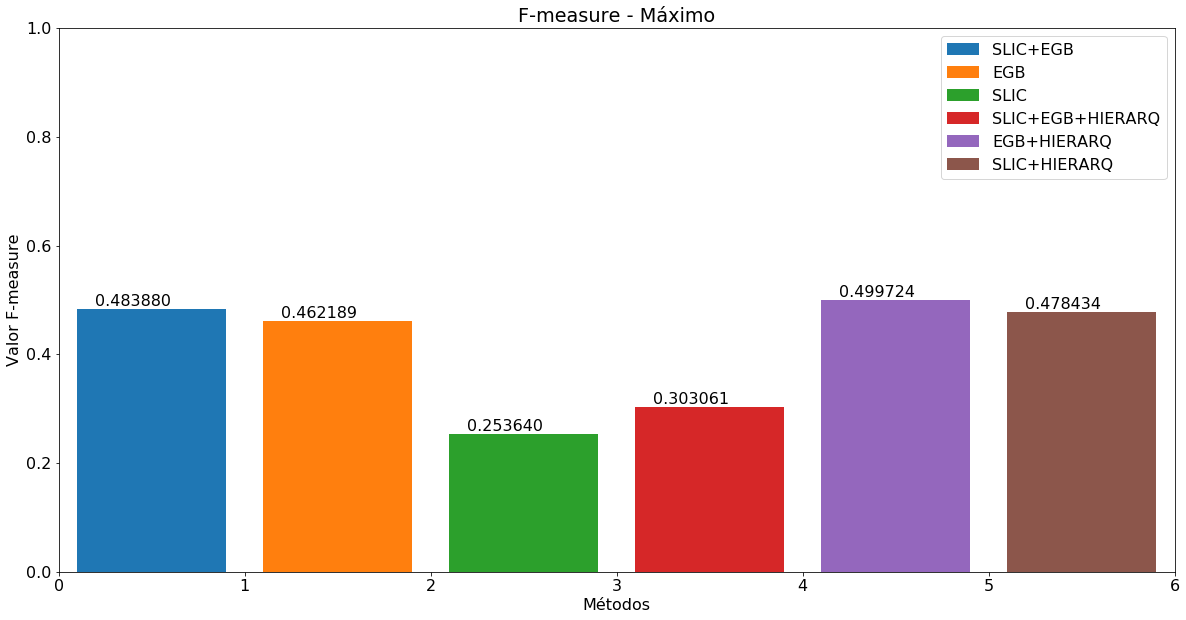

In [41]:
#plot curves
plt.figure(figsize=(20,10))

bar1 = plt.bar(0.5, max_measures[0], label='SLIC+EGB') #, marker='o', markersize=5, linewidth=0)
bar2 = plt.bar(1.5, max_measures[1], label='EGB')
bar3 = plt.bar(2.5, max_measures[2], label='SLIC')
bar4 = plt.bar(3.5, max_measures[3], label='SLIC+EGB+HIERARQ')
bar5 = plt.bar(4.5, max_measures[4], label='EGB+HIERARQ')
bar6 = plt.bar(5.5, max_measures[5], label='SLIC+HIERARQ')

plt.rcParams["font.size"] = 16
plt.legend(loc=0.)
plt.axis([0, 6, 0, 1])

for rect in (bar1 + bar2 + bar3 + bar4 + bar5 + bar6):
    height = rect.get_height()
    plt.text(rect.get_x()+0.3, height, '%2f' % height, ha='center', va='bottom')

plt.xlabel('Métodos')
plt.ylabel('Valor F-measure')
plt.title('F-measure - Máximo')
plt.show()